In [1]:
import pandas as pd
import json
import networkx as nx
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

# Prepare categories for nodes

In [2]:
G = pickle.load(open('Graph/unsigned_graph.pickle','rb'))

In [3]:
small = pickle.load(open('Graph/small/unsigned_graph.pickle','rb'))

In [4]:
videos = pd.read_json('Data/complete_videos_metadata.jsonl',lines=True,encoding='utf-8')

In [5]:
video_index=pickle.load(open('Graph/video_index','rb'))
node_index = {v: k for k, v in video_index.items()}

In [6]:
with open('./Data/categories.json') as file:
    categories = json.load(file)
category_dict = {int(i['id']):i['snippet']['title'] for i in categories}

In [7]:
for video in videos.to_dict(orient='records'):
    try:
        G.nodes[video_index[video['videoId']]]['category'] = int(video['category'])
    except:
        pass
    try:
        small.nodes[video_index[video['videoId']]]['category'] = int(video['category'])
    except:
        pass

## Analysis

Power law

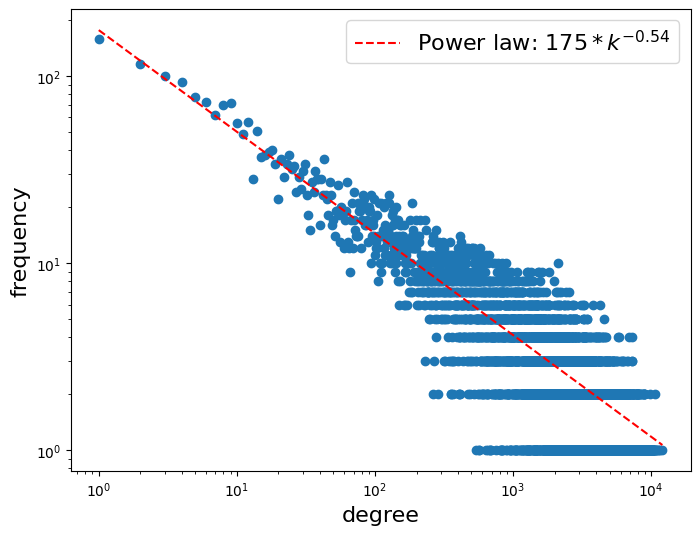

In [8]:
def func_powerlaw(k, alpha, c):
    return k**alpha * c

target_func = func_powerlaw

X, y = np.unique([G.degree(n) for n in G.nodes() if G.degree(n)], return_counts=True)

popt, pcov = curve_fit(target_func, X, y)

plt.figure(figsize=(8, 6))
plt.plot(X, target_func(X, *popt), '--',color='r',label=r'Power law: $175*k^{-0.54}$')
plt.scatter(X,y)
plt.loglog()
plt.xlabel('degree',fontsize=16)
plt.ylabel('frequency',fontsize=16)
plt.legend(fontsize=16)
plt.savefig('figures/all_nodes_degrees.pdf',format='pdf')
plt.show()

In [9]:
popt

array([ -0.54336044, 175.79434689])

In [10]:
cross_category_degrees = {}
for node in tqdm(G.nodes):
    cross_category_degrees[node] = sum([1 for u,v in G.edges(node) if G.nodes[v]['category'] != G.nodes[u]['category']])

100%|██████████████████████████████████████████████████████████████████████████| 17941/17941 [00:14<00:00, 1278.87it/s]


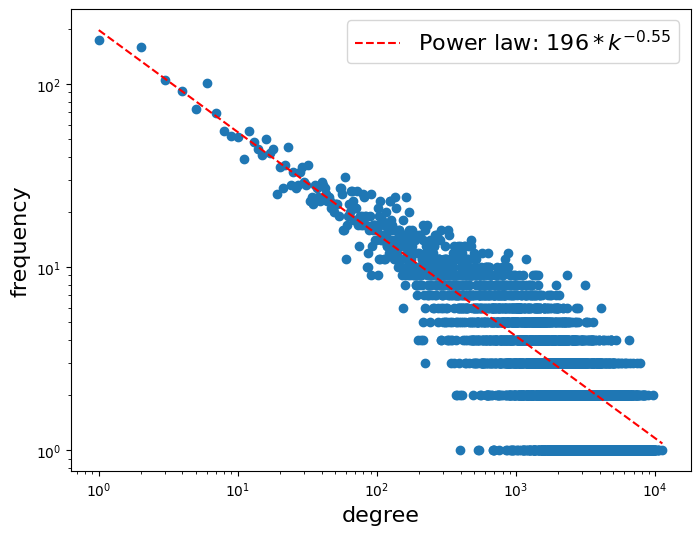

In [11]:
target_func = func_powerlaw

X, y = np.unique(list(cross_category_degrees.values()), return_counts=True)

X=X[1:]
y=y[1:]
popt, pcov = curve_fit(target_func, X, y)

plt.figure(figsize=(8, 6))
plt.plot(X, target_func(X, *popt), '--',color='r',label=r'Power law: $196*k^{-0.55}$')
plt.scatter(X,y)
plt.loglog()
plt.xlabel('degree',fontsize=16)
plt.ylabel('frequency',fontsize=16)
plt.legend(fontsize=16)
plt.savefig('figures/cross_category_nodes_degrees.pdf',format='pdf')
plt.show()

In [12]:
cross_category_edges = 0
for u,v in tqdm(G.edges):
    if G.nodes[u]['category']!=G.nodes[v]['category']:
        cross_category_edges+=1
print(f'Cross category edges makeup {cross_category_edges/len(G.edges)} of the network')

100%|█████████████████████████████████████████████████████████████████| 15142389/15142389 [00:09<00:00, 1655333.03it/s]

Cross category edges makeup 0.8853945701698721 of the network


In [13]:
#Correlation between node degree and video views
lines = [(node_index[n],G.degree(n)) for n in G.nodes() if G.degree(n)]
df = pd.DataFrame(lines,columns=['videoId','degree'])
df = pd.merge(df,videos,on='videoId')
df.head()

,videoId,degree,publishedAt,title,description,channelTitle,channelId,liveBroadCastContent,category,tags,language,duration,topics,viewCount,likeCount,favoriteCount,commentCount,method
0,BktoG1cjAPw,77,2019-02-15T13:00:02Z,🎥 RALPH BREAKS THE INTERNET - Wreck-It Ralph 2...,"Six years after the events of ""Wreck-It Ralph,...",TRAILER CITY,UCM1LVD5a5509fzL-4khritA,False,1,"[trailer, full movie trailer, new trailer, tra...",en,PT51S,"[https://en.wikipedia.org/wiki/Entertainment, ...",479139.0,1287.0,0.0,37.0,None
1,G0b85VCZfLk,2512,2021-01-23T16:10:01Z,SCP-4001 - Alexandria Eternal (SCP Animation),SCP-4001 is a Safe Class anomaly also known as...,SCP Explained - Story & Animation,UC8JfkMtNAp44vmzdtnL4wow,False,1,"[scp, scp foundation, animation, animated, sec...",,PT13M52S,"[https://en.wikipedia.org/wiki/Entertainment, ...",1361069.0,38145.0,0.0,2390.0,None
2,mDb2_NkDSvU,1259,2016-11-30T23:31:36Z,How &quot;Doubt&quot; Works the Tension in the...,Doubt is one of those movies you've heard abou...,AustinMcConnell,UCbxQcz9k0NRRuy0ukgQTDQQ,False,1,"[Doubt, doubt film, doubt (2008), philip seymo...",,PT12M54S,"[https://en.wikipedia.org/wiki/Entertainment, ...",173103.0,6175.0,0.0,481.0,None
3,HiDmhFTlcI4,1348,2020-07-27T21:56:20Z,One X-Cellent Scene: The Cage Fight That Began...,"In this One X-Cellent Scene video, we break do...",ScreenCrush,UCgMJGv4cQl8-q71AyFeFmtg,False,1,"[one x-cellent scene, x-men, x-cellent scene s...",en,PT7M17S,"[https://en.wikipedia.org/wiki/Entertainment, ...",189950.0,7750.0,0.0,608.0,None
4,kj1hLFSORTQ,2363,2020-01-21T21:56:28Z,The Secret to Superhuman Performance,Go to http://dashlane.com/matt to get a 30 day...,Matt D'Avella,UCJ24N4O0bP7LGLBDvye7oCA,False,1,"[peak performance, flow, the flow state, human...",,PT10M31S,[https://en.wikipedia.org/wiki/Lifestyle_(soci...,1158845.0,52325.0,0.0,1427.0,None


In [14]:
print("Correlation:",df['degree'].corr(df['commentCount'],'spearman'))

Correlation: 0.8737891768610376


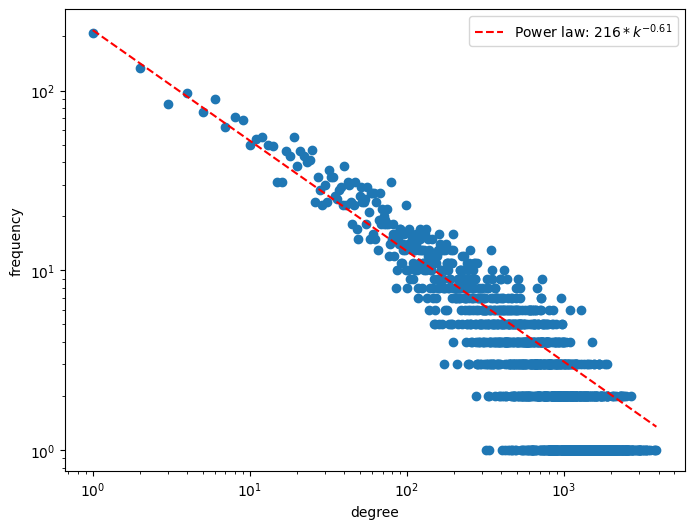

In [15]:
target_func = func_powerlaw

X, y = np.unique([small.degree(n) for n in small.nodes() if small.degree(n)], return_counts=True)

popt, pcov = curve_fit(target_func, X, y)

plt.figure(figsize=(8, 6))
plt.plot(X, target_func(X, *popt), '--',color='r',label=r'Power law: $216*k^{-0.61}$')
plt.scatter(X,y)
plt.loglog()
plt.xlabel('degree')
plt.ylabel('frequency')
plt.legend()
plt.savefig('figures/small_nodes_degrees.pdf',format='pdf')
plt.show()

In [16]:
small_category_degrees = {}
for node in tqdm(small.nodes):
    small_category_degrees[node] = sum([1 for u,v in small.edges(node) if small.nodes[v]['category'] != small.nodes[u]['category']])

100%|████████████████████████████████████████████████████████████████████████████| 8332/8332 [00:01<00:00, 6475.25it/s]


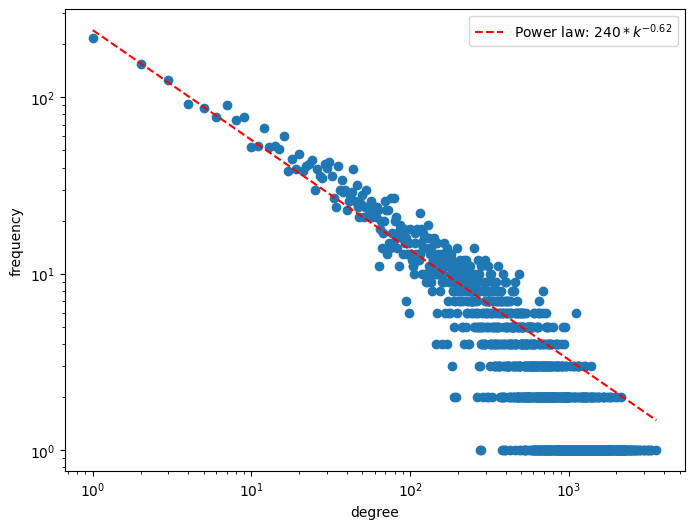

In [17]:
target_func = func_powerlaw

X, y = np.unique(list(small_category_degrees.values()), return_counts=True)

X=X[1:]
y=y[1:]
popt, pcov = curve_fit(target_func, X, y)

plt.figure(figsize=(8, 6))
plt.plot(X, target_func(X, *popt), '--',color='r',label=r'Power law: $240*k^{-0.62}$')
plt.scatter(X,y)
plt.loglog()
plt.xlabel('degree')
plt.ylabel('frequency')
plt.legend()
plt.savefig('figures/small_cross_category_nodes_degrees.pdf',format='pdf')
plt.show()

Graph components

In [18]:
n_cc = nx.number_connected_components(G)

In [19]:
connected_components = nx.connected_components(G)

In [20]:
component_lengths = []
components=[]
for component in connected_components:
    component_lengths.append(len(component))
    components.append(component)

In [21]:
component_lengths = np.array(component_lengths)

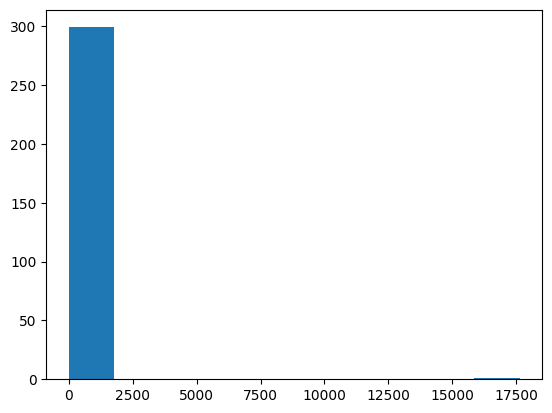

In [22]:
plt.hist(component_lengths)
plt.show()

In [23]:
print("Componentes conectados: ",n_cc)
print("Componentes com comprimento maior do que 2:",np.count_nonzero(component_lengths>2))

Componentes conectados:  300
Componentes com comprimento maior do que 2: 2


In [24]:
print('Nodes outside of main_component:',sum(len(c) for c in components[1:])/len(G.nodes))
print('Nodes outside of main_component:',sum(len(G.edges(n)) for c in components[1:] for n in c)/len(G.nodes))

Nodes outside of main_component: 0.017724764505880387
Nodes outside of main_component: 0.005239395797335711


In [25]:
#find which are the categories for the small components
categories_of_components = [np.array([G.nodes[n]['category'] for n in c ]) for c in components[1:]]
categories_of_components

[array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([2]),
 array([2]),
 array([2]),
 array([2]),
 array([2]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10, 10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([10]),
 array([

In [26]:
#find the composition for the small components
component_composition = [np.unique(x, return_counts=True) for x in categories_of_components if len(x)>1]
component_composition

[(array([10]), array([2], dtype=int64)),
 (array([17]), array([2], dtype=int64)),
 (array([22]), array([2], dtype=int64)),
 (array([22]), array([2], dtype=int64)),
 (array([22]), array([2], dtype=int64)),
 (array([22, 27]), array([2, 7], dtype=int64)),
 (array([28]), array([2], dtype=int64)),
 (array([22]), array([2], dtype=int64)),
 (array([2]), array([2], dtype=int64)),
 (array([1]), array([2], dtype=int64)),
 (array([10]), array([2], dtype=int64)),
 (array([28]), array([2], dtype=int64))]

In [27]:
#print categories for the mixed component to have the name for the report
print(category_dict[22])
print(category_dict[27])

People & Blogs
Education


In [28]:
#find the proportion for the small components
proportions = [y/sum(y) for x,y in component_composition]
proportions

[array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([0.22222222, 0.77777778]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.])]

In [29]:
unconnected_categories = [G.nodes[n]['category'] for c in components[1:] for n in c ]
unconnected_categories = {x:unconnected_categories.count(x) for x in unconnected_categories}
unconnected_categories

{1: 46,
 2: 17,
 10: 51,
 15: 11,
 17: 11,
 19: 23,
 22: 53,
 27: 29,
 24: 7,
 25: 8,
 26: 9,
 28: 23,
 29: 25,
 23: 2,
 20: 3}

In [30]:
#find which fraction of each category is unconnected to the big component
for c in unconnected_categories:
    print(category_dict[c]+': '+str(unconnected_categories[c]/len(df[df['category']==c])))

Film & Animation: 0.038917089678511
Autos & Vehicles: 0.011470985155195682
Music: 0.042677824267782424
Pets & Animals: 0.00864100549882168
Sports: 0.013095238095238096
Travel & Events: 0.01711309523809524
People & Blogs: 0.04243394715772618
Education: 0.03598014888337469
Entertainment: 0.006566604127579738
News & Politics: 0.006878761822871883
Howto & Style: 0.006442376521116679
Science & Technology: 0.023069207622868605
Nonprofits & Activism: 0.0273224043715847
Comedy: 0.0016570008285004142
Gaming: 0.0019505851755526658


Centrality

In [31]:
%%time
page_rank = nx.pagerank(G,max_iter=300)

CPU times: total: 31.3 s
Wall time: 48.5 s


In [32]:
sortedpage_rank = sorted(page_rank.items(), key=lambda x:x[1])

In [33]:
#get categories for top .1% nodes
categorias_top1=[]
for i,tup in enumerate(sortedpage_rank[::-1]):
    if i > int(len(sortedpage_rank)/100):
        break
    categorias_top1.append(node_index[tup[0]])
categorias_top1 = df[df['videoId'].isin(categorias_top1)]['category']

In [34]:
round(categorias_top1.apply(lambda cat: category_dict[cat]).value_counts()/len(categorias_top1),2)

category
News & Politics          0.30
Comedy                   0.12
Education                0.09
Pets & Animals           0.08
Autos & Vehicles         0.07
Science & Technology     0.07
Travel & Events          0.07
People & Blogs           0.06
Entertainment            0.06
Nonprofits & Activism    0.04
Film & Animation         0.01
Sports                   0.01
Howto & Style            0.01
Name: count, dtype: float64

In [35]:
G_no_cross_category = G.copy()

In [35]:
cross_category_edges = 0
for u,v in tqdm(G.edges):
    if G_no_cross_category.nodes[u]['category']!=G_no_cross_category.nodes[v]['category']:
        G_no_cross_category[u][v]['weight']=10**-10

  0%|                                                                                     | 0/15142389 [00:00<?, ?it/s]


NameError: name 'G_no_cross_category' is not defined

In [37]:
len(G.nodes)

17941

In [38]:
%%time
page_rank = nx.pagerank(G_no_cross_category,max_iter=300)
sortedpage_rank = sorted(page_rank.items(), key=lambda x:x[1])
#get categories for top .1% nodes
categorias_top1=[]
for i,tup in enumerate(sortedpage_rank[::-1]):
    if i > int(len(sortedpage_rank)/100):
        break
    categorias_top1.append(node_index[tup[0]])
categorias_top1 = df[df['videoId'].isin(categorias_top1)]['category']

CPU times: total: 43.6 s
Wall time: 1min 3s


In [39]:
round(categorias_top1.apply(lambda cat: category_dict[cat]).value_counts()/len(categorias_top1),2)

category
Howto & Style            0.18
Gaming                   0.14
Entertainment            0.11
People & Blogs           0.11
Nonprofits & Activism    0.10
Education                0.08
Autos & Vehicles         0.07
Music                    0.07
Pets & Animals           0.04
Film & Animation         0.03
Science & Technology     0.03
Travel & Events          0.02
Comedy                   0.02
News & Politics          0.01
Name: count, dtype: float64

In [40]:
len(categorias_top1)

180

Transições

In [ ]:
merged_graph = nx.Graph()
merged_graph.add_nodes_from(list(category_communities.keys()))
for node in merged_graph.nodes:
    merged_graph.nodes[node]['name'] = category_dict[node]

In [82]:
for node in merged_graph.nodes:
    for node2 in merged_graph.nodes:
        merged_graph.add_edge(node,node2,weight=0)

In [83]:
for u,v in tqdm(G.edges):
    u_category = id_category_mapping[node_index[u]]
    v_category = id_category_mapping[node_index[v]]
    merged_graph[u_category][v_category]['weight'] += G[u][v]['weight']

100%|██████████████████████████████████████████████████████████████████| 15142389/15142389 [00:17<00:00, 885992.73it/s]


In [84]:
merged_graph =merged_graph.to_directed()

In [92]:
for n in merged_graph.nodes:
    total_weight=0
    for u,v in merged_graph.edges(n):
        total_weight+=merged_graph[u][v]['weight']
    for u,v in merged_graph.edges(n):
        merged_graph[u][v]['weight']/=total_weight

In [ ]:
A = nx.adjacency_matrix(merged_graph)

In [ ]:
labels=[]
for category in merged_graph.nodes():
    labels.append(category_dict[category])

In [ ]:
sns.set(rc={'figure.figsize':(12,12)})
sns.set(font_scale=1.4)
sns.heatmap(A.todense(),annot=True,fmt='.2f',annot_kws={"fontsize":15},xticklabels=labels,yticklabels=labels)
plt.tight_layout()
plt.savefig('figures/transitionmatrix.pdf',format='pdf')
plt.show()

In [ ]:
nx.write_gexf(merged_graph, "figures/merged_graph.gexf")

Modularidade

In [36]:
for component in components:
    if len(component) <10:
        G.remove_nodes_from(component)

In [37]:
#get communities for each category
category_communities = {}
for node in G.nodes:
    if not G.nodes[node]['category'] in category_communities:
        category_communities[G.nodes[node]['category']]=set()
    category_communities[G.nodes[node]['category']].add(node)

In [38]:
#get the modularity of the network partitioned by categories
modularity_score = nx.community.modularity(G,list(category_communities.values()))

In [39]:
modularity_score

0.2194072556253389

In [40]:
communities = nx.community.greedy_modularity_communities(G,weight='weight',cutoff=videos['category'].nunique(),best_n=videos['category'].nunique())

In [42]:
#get the modularity of the network partitioned by categories
modularity_score_communities = nx.community.modularity(G,communities)

In [44]:
modularity_score_communities

0.32805491268415266

In [46]:
[len(community) for community in communities]

[4658, 4068, 3069, 2133, 1207, 833, 673, 480, 276, 215, 3, 2, 2, 2, 2]

In [95]:
#
most_similar = []
for i,community in enumerate(communities):
    similar = []
    max_jaccard = 0
    for category,cc in category_communities.items():
        similarity = len(cc.intersection(community))/len(community)
        similar.append((category,jaccard))
    most_similar.append((sorted(similar,key=lambda x:x[0]),i))

In [117]:
def format_similarities(most_similar):
    macrotext=''
    for l,community in most_similar:
        l = sorted(l,key=lambda key:-key[1])
        s=0
        text = '\\item '
        for category,percentage in l:
            if s >= 0.5:
                text=text.rstrip(' + ')+'\n'
                break
            s+=percentage
            text += f'{category_dict[category]}({percentage:.2f}) + '
        macrotext+=text
    return macrotext

In [118]:
print(format_similarities(most_similar))

\item Gaming(0.14) + Comedy(0.09) + Entertainment(0.09) + Pets & Animals(0.08) + People & Blogs(0.08) + Film & Animation(0.08)
\item News & Politics(0.15) + Travel & Events(0.15) + Comedy(0.13) + Nonprofits & Activism(0.13)
\item Film & Animation(0.14) + People & Blogs(0.14) + Entertainment(0.10) + Music(0.09) + Education(0.08)
\item Autos & Vehicles(0.47) + Science & Technology(0.15)
\item Sports(0.38) + Gaming(0.15)
\item Pets & Animals(0.34) + Howto & Style(0.10) + Travel & Events(0.10)
\item Gaming(0.64)
\item Music(0.33) + Education(0.13) + Film & Animation(0.12)
\item Travel & Events(0.18) + Sports(0.14) + People & Blogs(0.13) + Pets & Animals(0.11)
\item Howto & Style(0.47) + Science & Technology(0.20)
\item Travel & Events(1.00)
\item Music(1.00)
\item Pets & Animals(1.00)
\item Travel & Events(1.00)
\item Pets & Animals(1.00)

